In [4]:
import pickle
import argparse
import itertools

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import scipy

import sys
sys.path.append('../scripts/observation')

import dolmino_sampling_sweep as dm

In [23]:
def z_to_p(z_score, eps=1e-6):
    return scipy.stats.norm.sf(z_score) + eps

def get_base_args(save_dir):
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--save_dir", type=str, required=True)
    parser.add_argument("--model_size", type=str, default="1B")
    parser.add_argument("--sampling_model_id", type=int, default=0)
    parser.add_argument("--max_tokens", type=int, default=32)
    parser.add_argument("--prompt", type=str, default=None)

    base_args = parser.parse_args(["--save_dir", save_dir])

    base_args.model_name = dm.MODEL_NAME_DICT[base_args.model_size]
    base_args.revision_template = dm.REVISION_TEMPLATE_DICT[base_args.model_size]

    return base_args

def fix_args(args):
    args.model_name = dm.MODEL_NAME_DICT[args.model_size]
    args.revision_template = dm.REVISION_TEMPLATE_DICT[args.model_size]

    return args

def fix_arg_order(args):
    ordered_args = argparse.Namespace()

    ordered_args.save_dir = args.save_dir
    ordered_args.model_size = args.model_size
    ordered_args.sampling_model_id = args.sampling_model_id
    ordered_args.max_tokens = args.max_tokens
    ordered_args.prompt = args.prompt

    ordered_args.model_name = args.model_name
    ordered_args.revision_template = args.revision_template
    
    ordered_args.n_sample = args.n_sample
    ordered_args.sampling_seed = args.sampling_seed
    ordered_args.temperature = args.temperature

    return ordered_args


def get_experiment(experiment_config, new_root='../dolmino-stuff', old_root='./dolmino-stuff'):
    base_args = get_base_args(save_dir=old_root)
    args = dm.build_args(base_args,experiment_config)
    args = fix_args(args)
    args = fix_arg_order(args)

    old_path = dm.get_experiment_log_path(args)
    relative_path = os.path.relpath(old_path, old_root)
    new_path = os.path.join(new_root, relative_path)

    experiment_result = pickle.load(open(new_path,'rb'))
    
    return experiment_result
    

def get_experiment_sweep(
    base_config, 
    sweep_param, 
    sweep_values, 
    transform=None, 
    seed_configs=None, 
    new_root='../dolmino-stuff', 
    old_root='./dolmino-stuff'
):
    if seed_configs is None:
        seed_configs = {"sampling_seed": list(range(10)),"sampling_model_id": list(range(3))}
    
    sweep_results = {
        "median": dict(),
        "q25": dict(),
        "q75": dict()
    }

    seed_names = list(seed_configs.keys())
    seed_values = [seed_configs[name] for name in seed_names]
    seed_combinations = list(itertools.product(*seed_values))
    
    for sweep_value in sweep_values:
        results = []
        for seeds in seed_combinations:
            seed_config = dict(zip(seed_names, seeds))
            
            experiment_config = {k : v for k,v in base_config.items()}
            experiment_config.update(seed_config)
            
            experiment_config[sweep_param] = sweep_value
            
            experiment_result = get_experiment(experiment_config, new_root, old_root)
            results.append(experiment_result["z_score"])

        if transform is not None:
            results = [transform(x) for x in results]
        
        sweep_results["median"][sweep_value] = np.median(results)
        sweep_results["q25"][sweep_value] = np.percentile(results, 25)
        sweep_results["q75"][sweep_value] = np.percentile(results, 75)

    return sweep_results

def get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values,
    xlabel=None,
    ylabel="p-value",
    styles=None,
    colors=None,
    in_legend=True,
    x_transform=None,
    y_transform=z_to_p,
    seed_configs=None, 
    new_root='../dolmino-stuff', 
    old_root='./dolmino-stuff',
    error_bars=True,
):
    if xlabel is None:
        xlabel = sweep_param
    if in_legend is True:
        in_legend = [True] * len(plot_configs)
    sns.set_theme()
    sns.set_palette("mako")
    plt.figure() 
    for i,(base_config,legend_tag) in enumerate(zip(plot_configs,plot_names)):
        sweep_results = get_experiment_sweep(
            base_config=base_config, 
            sweep_param=sweep_param, 
            sweep_values=sweep_values, 
            seed_configs=seed_configs,
            transform=y_transform,
            new_root=new_root,
            old_root=old_root,
        )
    
        xs = list(sweep_results['median'].keys())
        
        m  = np.array([sweep_results['median'][x] for x in xs], float)
        q25  = np.array([sweep_results['q25'][x]  for x in xs],  float)
        q75  = np.array([sweep_results['q75'][x]  for x in xs],  float)

        print(legend_tag)
        print(f"xs: {xs}")
        print(f"m: {m}")
        print(f"q25: {q25}")
        print(f"q75: {q75}")

        style = styles[i] if styles else '-'
        color = colors[i] if colors else None
        include = in_legend[i]

        if x_transform is not None:
            xs = [x_transform(x) for x in xs]
        
        plt.plot(xs, m, label=legend_tag if include else None, linestyle=style, color=color)
        if error_bars:
            plt.fill_between(xs, q25, q75, alpha=0.2, color=color)

    plt.yscale('log')
    plt.ylim(top=1)
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'$10^{{-{-np.log10(x):.0f}}}$'))    
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()

def get_colors(k):
    # return plt.rcParams['axes.prop_cycle'].by_key()['color'][:k]
    return sns.color_palette("mako", n_colors=k)

hello
m: [3.69780664e-01 1.29806970e-01 9.92484752e-02 4.53074616e-03
 1.43795915e-03 6.00099459e-03 2.46098426e-04]
q25: [2.73151073e-05 5.43919689e-03 3.03474197e-05 1.02617170e-06
 1.00870981e-06 1.00000085e-06 1.00003533e-06]
q75: [0.75450227 0.30034424 0.32233344 0.0489835  0.06003433 0.04673484
 0.01297947]


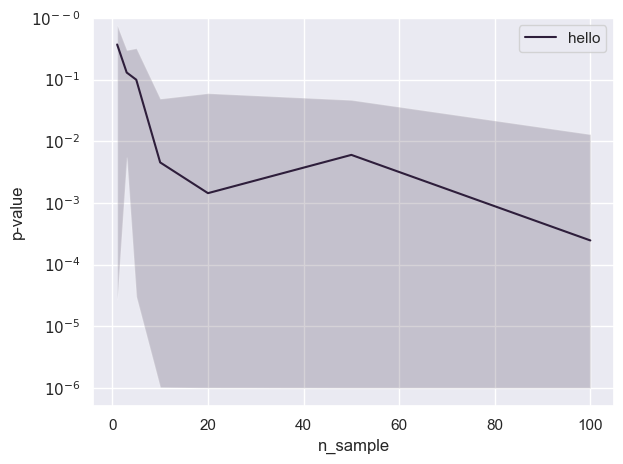

In [20]:
base_config = {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "7B"
    }
sweep_param = "n_sample"
sweep_values = [1, 3, 5, 10, 20, 50, 100]

get_plot([base_config], ["hello"], sweep_param, sweep_values)

hello
m: [0.17386375 0.09689861 0.11462815 0.1252186  0.00625472 0.00981893
 0.00156227]
q25: [4.36774815e-03 1.00029995e-06 3.38296397e-05 6.51992227e-03
 6.44359486e-05 2.76455513e-05 1.13560246e-06]
q75: [0.46054051 0.32864654 0.22281983 0.27627702 0.14467635 0.07363021
 0.02771479]


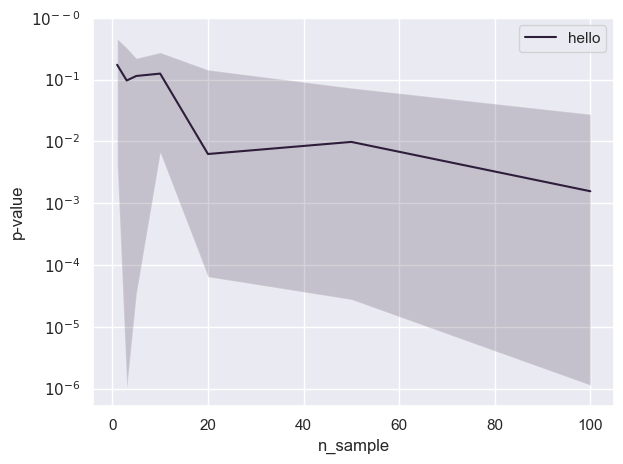

In [21]:
base_config = {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "1B"
    }
sweep_param = "n_sample"
sweep_values = [1, 3, 5, 10, 20, 50, 100]

get_plot([base_config], ["hello"], sweep_param, sweep_values)

1B
xs: [1, 3, 5, 10, 20, 50, 100]
m: [0.17386375 0.09689861 0.11462815 0.1252186  0.00625472 0.00981893
 0.00156227]
q25: [4.36774815e-03 1.00029995e-06 3.38296397e-05 6.51992227e-03
 6.44359486e-05 2.76455513e-05 1.13560246e-06]
q75: [0.46054051 0.32864654 0.22281983 0.27627702 0.14467635 0.07363021
 0.02771479]
7B
xs: [1, 3, 5, 10, 20, 50, 100]
m: [3.69780664e-01 1.29806970e-01 9.92484752e-02 4.53074616e-03
 1.43795915e-03 6.00099459e-03 2.46098426e-04]
q25: [2.73151073e-05 5.43919689e-03 3.03474197e-05 1.02617170e-06
 1.00870981e-06 1.00000085e-06 1.00003533e-06]
q75: [0.75450227 0.30034424 0.32233344 0.0489835  0.06003433 0.04673484
 0.01297947]


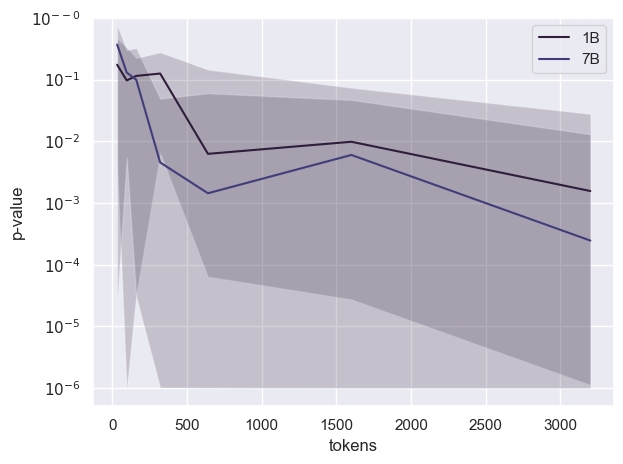

In [24]:
base_configs = [
    {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "1B"
    },
    {
        "save_dir": './dolmino-stuff',
        "temperature": 1.0,
        "model_size": "7B"
    },
]
sweep_param = "n_sample"
sweep_values = [1, 3, 5, 10, 20, 50, 100]

get_plot(
    plot_configs=base_configs, 
    plot_names=["1B","7B"], 
    sweep_param=sweep_param, 
    sweep_values=sweep_values,
    x_transform=lambda x : 32*x,
    xlabel="tokens"
)

In [26]:
base_configs = [
    {
        "save_dir": './dolmino-stuff',
        "temperature": 0.5,
        "model_size": "1B"
    },
    {
        "save_dir": './dolmino-stuff',
        "temperature": 0.5,
        "model_size": "7B"
    },
]
sweep_param = "n_sample"
sweep_values = [10, 20, 50]

get_plot(
    plot_configs=base_configs, 
    plot_names=["1B","7B"], 
    sweep_param=sweep_param, 
    sweep_values=sweep_values,
    x_transform=lambda x : 32*x,
    xlabel="tokens"
)

FileNotFoundError: [Errno 2] No such file or directory: '../dolmino-stuff/experiment_logs/ae53f799dcb1b112/log.pkl'

<Figure size 640x480 with 0 Axes>